# Unsupervised Learning
This notebook demonstrates unsupervised learning techniques. 

If you are interested in identifying hidden patterns in data, specifically unlabelled (or unstructured) data, then this notebook will help guide you through unsupervised learning from data with Python. We'll use some key Python statistics and machine learning libaries:

* `sci-kit learn`
* `statsmodels`

For data, we've already collected over 200 speeches from the U.S. Secretary of Defense from the last 4 years. If you're curious to learn about webscraping or how this data was acquired, check out the notebook `data_collection.ipynb`. This is _text_, so it is inherently unstructured data. We'll use some basic natural language processing (NLP) techniques to convert this text into structured data.

Let's get started by importing some packages we'll need:

In [1]:
import numpy as np
import pandas as pd
import re

import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn import feature_extraction
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity

import hdbscan

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Dealing with stopwords

Now, let's make sure that we have loaded NLTK's (a key Python NLP library) stopwords:

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandon/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Stopwords are words that are common to language and are important in context, but don't carry significant semantic meaning with respect to an overall text. For example, if you were looking at a news article about nuclear weapons in North Korea you could determine what the article was about based on the frequency of words like "nuclear", "weapons", and "North Korea". You wouldn't be able to learn much from words like "who", "when", "our", "me", etc.

Let's load nltk's English stopwords as variable called `stopwords`:

In [3]:
stopwords = stopwords.words('english')
print(stopwords[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


### Tokenization and stemming

Next, we are going to define some functions to help us resolve words like "ran", "running", "runs" into a canonical (or _stemmed_) form (e.g. "run"). We'll use the NLTK [Snowball Stemmer](https://www.nltk.org/_modules/nltk/stem/snowball.html).

In [4]:
stemmer = SnowballStemmer("english")

In [5]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            if len(token) >= 4:
                filtered_tokens.append(token)
    return filtered_tokens

Note that we'll also need to **_tokenize_** the speeches. This is the process of converting text into words.

For example, we would take 
```
"The quick brown fox jumped over the lazy dog."
```

and tokenize it into:
```
["The", "quick", "brown", "fox", "jumped", "over", "the", "lazy", "dog", "."]
```

This lets us generate frequency counts of words within speeches.

### Parsing our data
Let's read in the speeches as a dataframe and take a look at what we're dealing with!

In [6]:
df = pd.read_csv('data/SecDef_Speeches.csv')
df.head()

,date,speech,title,url
0,"March 30, 2015",Good morning everyone! What a great looking cr...,Remarks by Secretary Carter on the Force of th...,https://www.defense.gov/News/Speeches/Speech-V...
1,"Jan. 11, 2017",Good evening everyone. Thanks for that kind i...,"Remarks on ""Defense at A Time Of Strategic Tra...",https://www.defense.gov/News/Speeches/Speech-V...
2,"Jan. 14, 2016","Ladies and gentlemen, excellencies, Congressma...",Remarks at SOUTHCOM Change of Command,https://www.defense.gov/News/Speeches/Speech-V...
3,"Nov. 14, 2014","Good morning. Earlier this year, following rev...",Statement on the Nuclear Enterprise Review & R...,https://www.defense.gov/News/Speeches/Speech-V...
4,"April 27, 2016","I. PURPOSE OF THIS TESTIMONY Chairman Cochran,...",Submitted Statement -- Senate Appropriations C...,https://www.defense.gov/News/Speeches/Speech-V...


Now we can tokenize and stem the speeches:

In [7]:
totalvocab_stemmed = []
totalvocab_tokenized = []

for i in df.speech:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

We need to generate a vocabulary: this will be a mapping from stemmed version of words back to their original form. That way we can lookup a stemmed word and back into what it actually was (in human readable form).

In [8]:
vocab = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print('There are ' + str(vocab.shape[0]) + ' items in our vocabulary.')

There are 302045 items in our vocabulary.


### tf-idf and calculating document similarity
To get a ff-idf matrix, first count word occurrences by document. This is transformed into a document-term matrix (dtm). This is also just called a term frequency matrix.

Then apply the term frequency-inverse document frequency weighting: words that occur frequently within a document but not frequently within the corpus receive a higher weighting as these words are assumed to contain more meaning in relation to the document. 

We will use this tf-idf matrix as a structured representation of the relationship between documents. We can use this to perform unsupervised learning: 

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.1, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(df.speech) #fit the vectorizer to speeches

print(tfidf_matrix.shape)

CPU times: user 11.9 s, sys: 102 ms, total: 12 s
Wall time: 12 s
(204, 1593)


Note that the tf-idf matrix has 204 rows (one for each speech) and 1,593 columns (one for each word which met the thresholds we specified for our `TfidfVectorizer`.

We can get all the terms from our tf-idf matrix:

In [10]:
terms = tfidf_vectorizer.get_feature_names()

### K-means clustering
Now we're ready to perform clustering on our speeches. We'll pick an arbitrary, but human understandable, number of clusters. Let's try for 12 clusters.

In [11]:
from sklearn.cluster import KMeans

num_clusters = 12

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 8.9 s, sys: 1.9 s, total: 10.8 s
Wall time: 2.99 s


We need to add the cluster labels to our dataset. This let's us see how many speeches ended up in each cluster:

In [12]:
df['cluster'] = clusters
df.groupby('cluster')['cluster'].count()

cluster
0     14
1     18
2     13
3     16
4     23
5     11
6     41
7      4
8     25
9     21
10    13
11     5
Name: cluster, dtype: int64

Now we can inspect the top terms in each of these clusters and compare them with the speech titles. This should give us a good sense of whether or not our clustering was successful.

In [13]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print("{0}Top terms per cluster:{1}".format(color.BOLD,color.END))
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("{0}Cluster {1} Words:{2}".format(color.BLUE + color.BOLD, i, color.END))
    
    for ind in order_centroids[i, :10]:
        word = str(vocab.loc[terms[ind].split(' ')].values.tolist()[0][0])
        print('\t-{0}'.format(word))
    print('')
    
    print("{0}Cluster {1} Speech Titles:\n{2}".format(color.GREEN + color.BOLD, i, color.END))
    titles = df[df['cluster'] == i].title
    for title in titles[:10]:
        print('\t- {0}'.format(title[:100]))
    print('\n\n')
    
print('\n')

Top terms per cluster:

Cluster 0 Words:
	-president
	-budget
	-health
	-sequestration
	-family
	-care
	-reforming
	-secretary
	-secretary
	-want

Cluster 0 Speech Titles:

	- Remarks at Armed Forces Farewell Parade for President Obama
	- Farewell Message to the Department of Defense From Secretary of Defense Chuck Hagel
	- Independence Day Message
	- Pentagon All-Hands Meeting
	- Armed Forces Day Message
	- Ceremonial Swearing-In
	- Remarks at the Global Health Security Agenda
	- Opening Summary -- House Armed Services Committee (Budget Request)
	- Remarks by Secretary Hagel at the White House
	- Opening Summary -- Senate Armed Services Committee (Budget Request)



Cluster 1 Words:
	-innovative
	-technologies
	-companies
	-future
	-things
	-board
	-investing
	-business
	-america
	-better

Cluster 1 Speech Titles:

	- "Defense Innovation Days" Opening Keynote (Southeastern New England Defense Industry Alliance)
	- Remarks on "Building the First Link to the Force of the Future" (George

### Visualizing our clusters

Let's use t-Distributed Stochastic Neighbor Embedding, or [t-SNE ](https://lvdmaaten.github.io/tsne/), for dimensionality reduction. This let's us project highly dimensional data, such as our tfidf matrix, into 2 dimensional space. This will let us visualize the clustering in 2-dimensions. Remember that much is lost projecting data with over 1500 features into 2d space!

In [14]:
data = tfidf_matrix.toarray()
projection = TSNE().fit_transform(data)

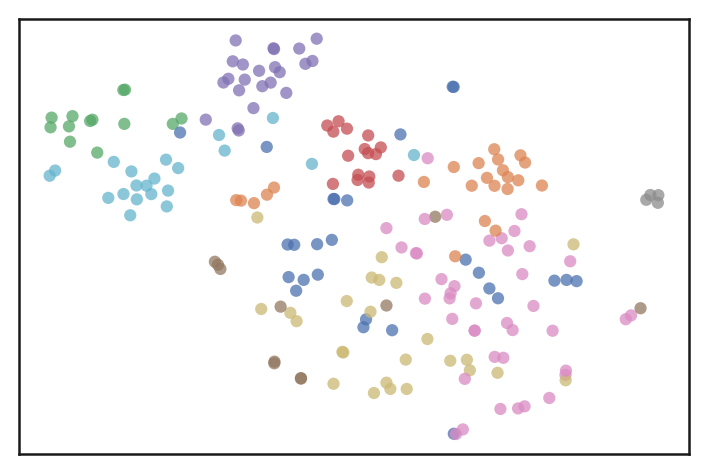

In [15]:
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'marker': 'o', 'alpha' : 0.75, 's' : 150, 'linewidths':0}

labels = clusters
palette = sns.color_palette(palette='deep', n_colors=np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(*projection.T, c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()

### DBSCAN
We can also try using Density-based spatial clustering of applications with noise (DBSCAN) to cluster the speeches. Note that DBSCAN doesn't require globular clusters, so we should expect a slightly different clustering.

First, let's calculate the cosine distance between each document. Let's use cosine distance instead of Euclidean distance as the measure of "closeness" between speeches. This is a common practice in NLP.

In [16]:
dist = 1 - cosine_similarity(tfidf_matrix)

In [17]:
print("The average cosine distance between speeches is {0}".format(np.average(dist)))

The average cosine distance between speeches is 0.8026433604271683


Now we can actually run the model, using our precomputed distance metrics. We can set epsilon (`eps`) to be 0.5 which is less than the average distance we calculated above. We'll also require that at least 3 speeches be in a cluster.

In [18]:
model = DBSCAN(eps=0.5, min_samples=3, metric='precomputed')

In [19]:
labels = model.fit_predict(dist)

Let's see how many clusters were found and how many speeches were left unclustered:

In [20]:
if -1 in labels:
    num_clusters = len(set(labels)) - 1
else:
    num_clusters = len(set(labels))
    
num_noise = len([i for i in labels if i == -1])
    
print("DBSCAN found {0} clusters".format(num_clusters))
print("{0} speeches were considered 'noise' and were not clustered.".format(num_noise))

DBSCAN found 7 clusters
96 speeches were considered 'noise' and were not clustered.


### Visualizing DBSCAN results:

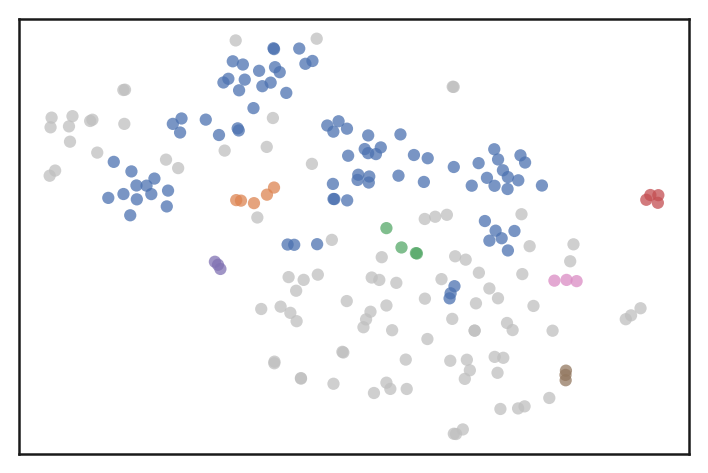

In [21]:
palette = sns.color_palette(palette='deep', n_colors=np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(*projection.T, c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()

### HDBSCAN
We can use the hierarchical form of DBSCAN, which doesn't require we specify a threshold for distance (`epsilon`) and see how it performs as well.

Here we can set the minimum number of speeches in a cluster. Let's select 4, which would dictate that we have at least 4 speeches in a cluster. `min_samples` is a measure of how conservative we would like the clustering to be--setting this value to `1` means we will not look at just high density clusters.

In [22]:
model = hdbscan.HDBSCAN(min_cluster_size=4, min_samples=1)

In [23]:
labels = model.fit_predict(dist)

In [24]:
if -1 in labels:
    num_clusters = len(set(labels)) - 1
else:
    num_clusters = len(set(labels))
    
num_noise = len([i for i in labels if i == -1])
    
print("HDBSCAN found {0} clusters".format(num_clusters))
print("{0} speeches were considered 'noise' and were not clustered.".format(num_noise))

HDBSCAN found 18 clusters
54 speeches were considered 'noise' and were not clustered.


### Visualizing HDBSCAN results

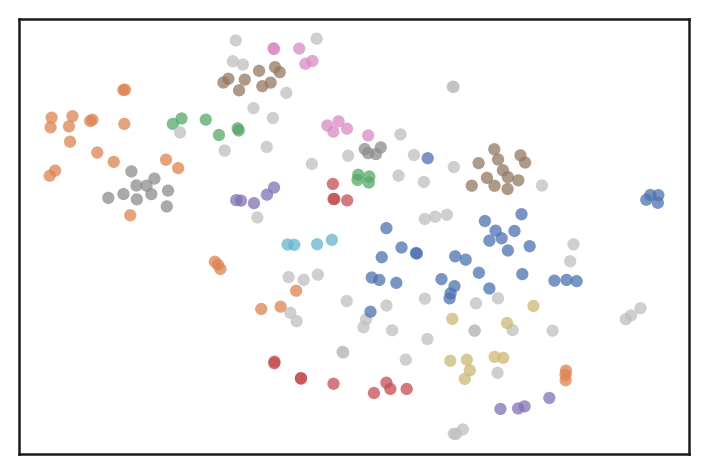

In [25]:
palette = sns.color_palette(palette='deep', n_colors=np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.75, 0.75, 0.75) for x in labels]

fig, ax = plt.subplots(figsize=(12, 8))
ax.margins(0.05)

plt.scatter(*projection.T, c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)


plt.show()